In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline 

In [21]:
base_bone_dir = os.path.join('..', 'input')
rsna_boneage = pd.read_csv(os.path.join(base_bone_dir, 'boneage-training-dataset.csv'))
rsna_boneage['path'] = rsna_boneage['id'].map(lambda x: os.path.join(base_bone_dir,
                                                         'boneage-training-dataset', 
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
rsna_boneage['exists'] = rsna_boneage['path'].map(os.path.exists)
print(rsna_boneage['exists'].sum(), 'images found of', rsna_boneage.shape[0], 'total')
rsna_boneage['gender'] = rsna_boneage['male'].map(lambda x : 'male' if x else 'female')
boneage_mean = rsna_boneage['boneage'].mean()
boneage_std = 2*rsna_boneage['boneage'].std()
rsna_boneage['boneage_zscore'] = rsna_boneage['boneage'].map(lambda x: (x-boneage_mean)/boneage_std)
rsna_boneage.dropna(inplace = True)

12611 images found of 12611 total


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5e9f77da0>,
      dtype=object)

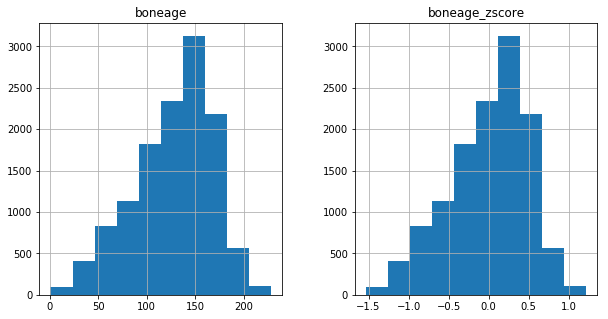

In [9]:
rsna_boneage[['boneage', 'boneage_zscore']].hist(figsize = (10, 5))

**Bucketize the age**

New Data Size: 8000 Old Size: 12611


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5e97496d8>]],
      dtype=object)

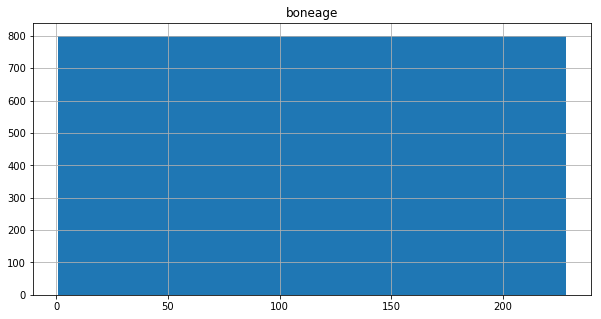

In [26]:
rsna_boneage['boneage_category'] = pd.cut(rsna_boneage['boneage'], 10)
rsna_boneage2 = rsna_boneage.groupby(['boneage_category', 'male']).apply(lambda val : val.sample(400, 
                                                                            replace=True)).reset_index(drop=True)
print('New Data Size:', rsna_boneage2.shape[0], 'Old Size:', rsna_boneage.shape[0])
rsna_boneage2[['boneage']].hist(figsize = (10, 5))

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.python import keras

rsna_train, rsna_test = train_test_split(rsna_boneage2, test_size = 0.23, random_state=800, 
                                        stratify = rsna_boneage2['boneage_category'])
print('Train data size : ',rsna_train.shape[0],'Test data size : ',rsna_test.shape[0])

Train data size :  6160 Test data size :  1840


In [29]:
from keras_preprocessing.image import ImageDataGenerator 
img_height, img_width = 512,512
img_trans = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization=True, 
                              width_shift_range=0.1, height_shift_range=0.1, horizontal_flip = True, 
                              vertical_flip = False, rotation_range = 10,shear_range = 0.05,
                              fill_mode = 'nearest',
                              zoom_range=0.15)

In [40]:
def flow_from_direct(data_gen, df, path_column, target_column, **args):
    base_directory = os.path.dirname(df[path_column].values[0])
    gen = data_gen.flow_from_directory(base_directory, class_mode = 'sparse',
                                      **args)
    gen.filenames = df[path_column].values
    gen.samples = df.shape[0]
    gen.classes = np.stack(df[target_column].values)
    gen.n = df.shape[0]
    gen._set_index_array()
    gen.directory = ''
    return gen

In [64]:
train_gen = flow_from_direct(img_trans, rsna_train, path_column='path', 
                                target_column = 'boneage_zscore',target_size=(img_height,img_width),
                            color_mode='grayscale',batch_size=64)

valid_gen = flow_from_direct(img_trans, rsna_test, 'path', 
                                target_column = 'boneage_zscore',target_size=(img_height,img_width),
                            color_mode='grayscale',batch_size=64)

## For evaluating the algorithm
test_x, test_target = next(flow_from_direct(img_trans, 
                               rsna_test, 
                             path_column = 'path',
                            target_column = 'boneage_zscore', 
                            target_size = (img_height,img_width),
                             color_mode = 'grayscale',
                            batch_size = 500)) 

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


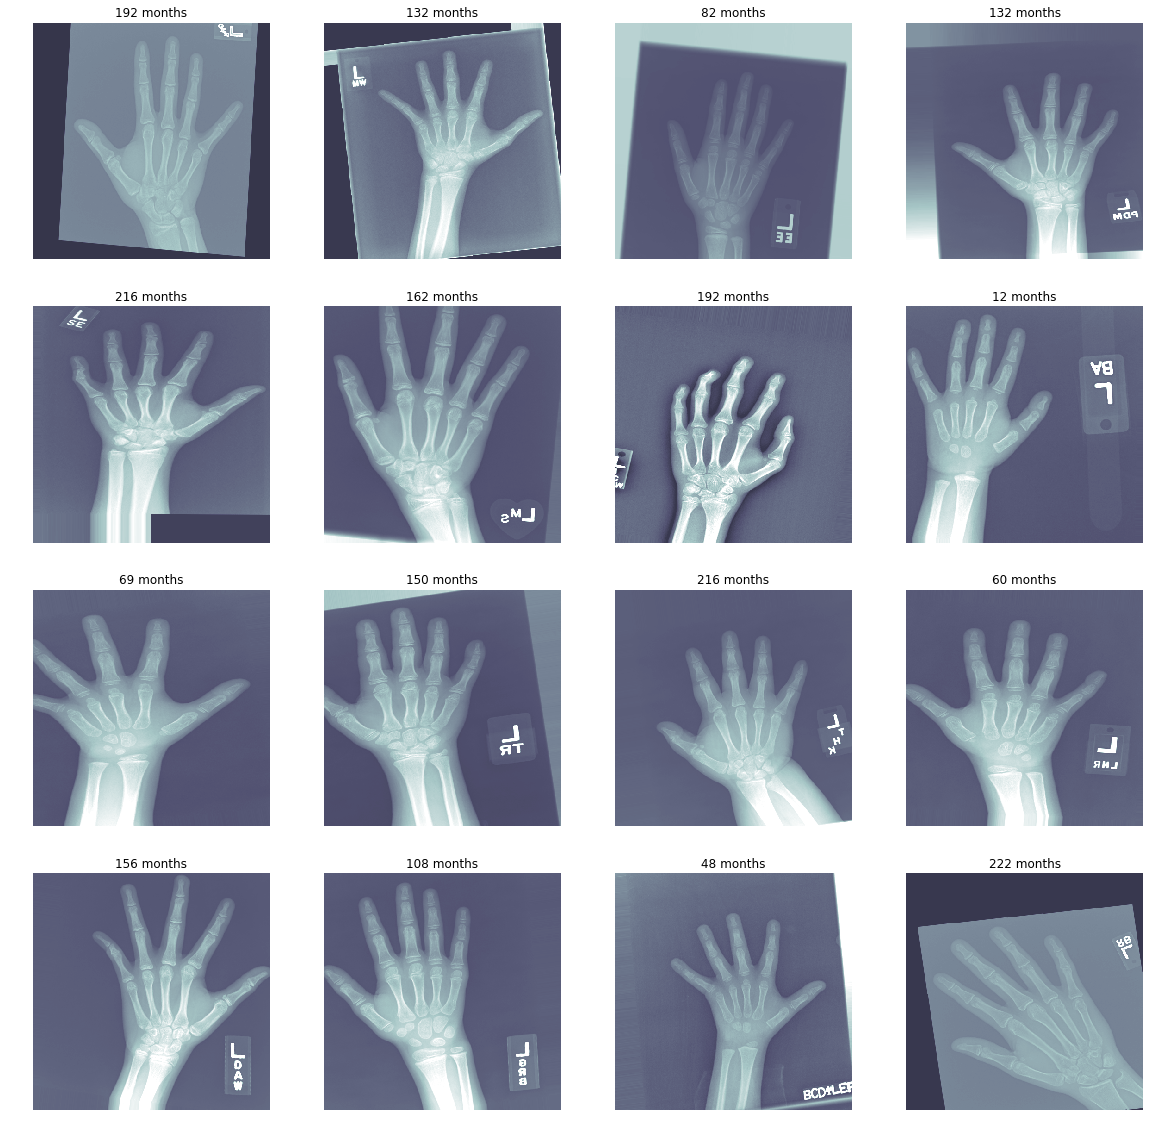

In [65]:
train_x, train_y = next(train_gen)
figure, axis = plt.subplots(4, 4, figsize = (20, 20))
for (x, y, axis_) in zip(train_x, train_y, axis.flatten()):
    axis_.imshow(x[:,:,0], cmap='bone', vmin=-3, vmax = 3)
    axis_.set_title('%.0f months' %(y*boneage_std+boneage_mean))
    axis_.axis('off')

In [66]:
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, GlobalAveragePooling2D, Dense, Flatten, BatchNormalization
from keras.models import Sequential
from keras.metrics import mean_absolute_error
mobile_net_model = MobileNet(input_shape = train_x.shape[1:], include_top=False, weights = None)
rsna_model = Sequential()
rsna_model.add(BatchNormalization(input_shape = train_x.shape[1:]))
## Add the mobile_net model into the model
rsna_model.add(mobile_net_model)
rsna_model.add(BatchNormalization())
rsna_model.add(GlobalAveragePooling2D())
## Adding Dropout with 50%
rsna_model.add(Dropout(0.5))
rsna_model.add(Dense(1, activation='linear'))


In [67]:
def months(value, pred):
    return mean_absolute_error(value*boneage_std, pred*boneage_std)

## Compiling the model
rsna_model.compile(optimizer='adam', loss='mse', metrics=[months])

rsna_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 512, 512, 1)       4         
_________________________________________________________________
mobilenet_1.00_512 (Model)   (None, 16, 16, 1024)      3228288   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 3,233,413
Trainable params: 3,209,475
Non-trainable params: 23,938
_____________________________________________________________

In [68]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

weights_path = '{}_weights.hdf5'.format('bone_age')
check_point = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, mode='min',
                              save_weights_only=True, save_best_only=True)
Learning_rate_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
                                   verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
stoppings = EarlyStopping(monitor='val_loss', mode='min', patience=5)
callbacks = [check_point, stoppings, Learning_rate_reduce]

In [82]:
## Specify batch size
train_gen.batch_size = 22

rsna_model.fit_generator(train_gen, epochs=9, validation_data=(test_x, test_target), callbacks=callbacks, steps_per_epoch=(train_x.shape[0]//22))

Epoch 1/9
2/2 [==============================] - 11s 5s/step - loss: 0.4448 - months: 48.6983 - val_loss: 18.8267 - val_months: 345.4944

Epoch 00001: val_loss did not improve from 0.59555
Epoch 2/9
2/2 [==============================] - 9s 5s/step - loss: 0.5262 - months: 48.2573 - val_loss: 15.7922 - val_months: 314.8397

Epoch 00002: val_loss did not improve from 0.59555
Epoch 3/9
2/2 [==============================] - 9s 5s/step - loss: 0.6838 - months: 53.6173 - val_loss: 1.2025 - val_months: 72.0982

Epoch 00003: val_loss did not improve from 0.59555
Epoch 4/9
2/2 [==============================] - 9s 5s/step - loss: 0.3580 - months: 38.1061 - val_loss: 2.7408 - val_months: 112.9505

Epoch 00004: val_loss did not improve from 0.59555
Epoch 5/9
2/2 [==============================] - 9s 5s/step - loss: 0.7639 - months: 54.8382 - val_loss: 13.1026 - val_months: 288.3023

Epoch 00005: val_loss did not improve from 0.59555
Epoch 6/9
2/2 [==============================] - 9s 5s/step - 

## Evaluating the model

In [83]:
rsna_model.load_weights(weights_path)

In [84]:
pred = boneage_std*rsna_model.predict(test_x, batch_size=20, verbose=True)+boneage_mean
test_month_target = boneage_std*test_target+boneage_mean

500/500 [==============================] - 7s 14ms/step


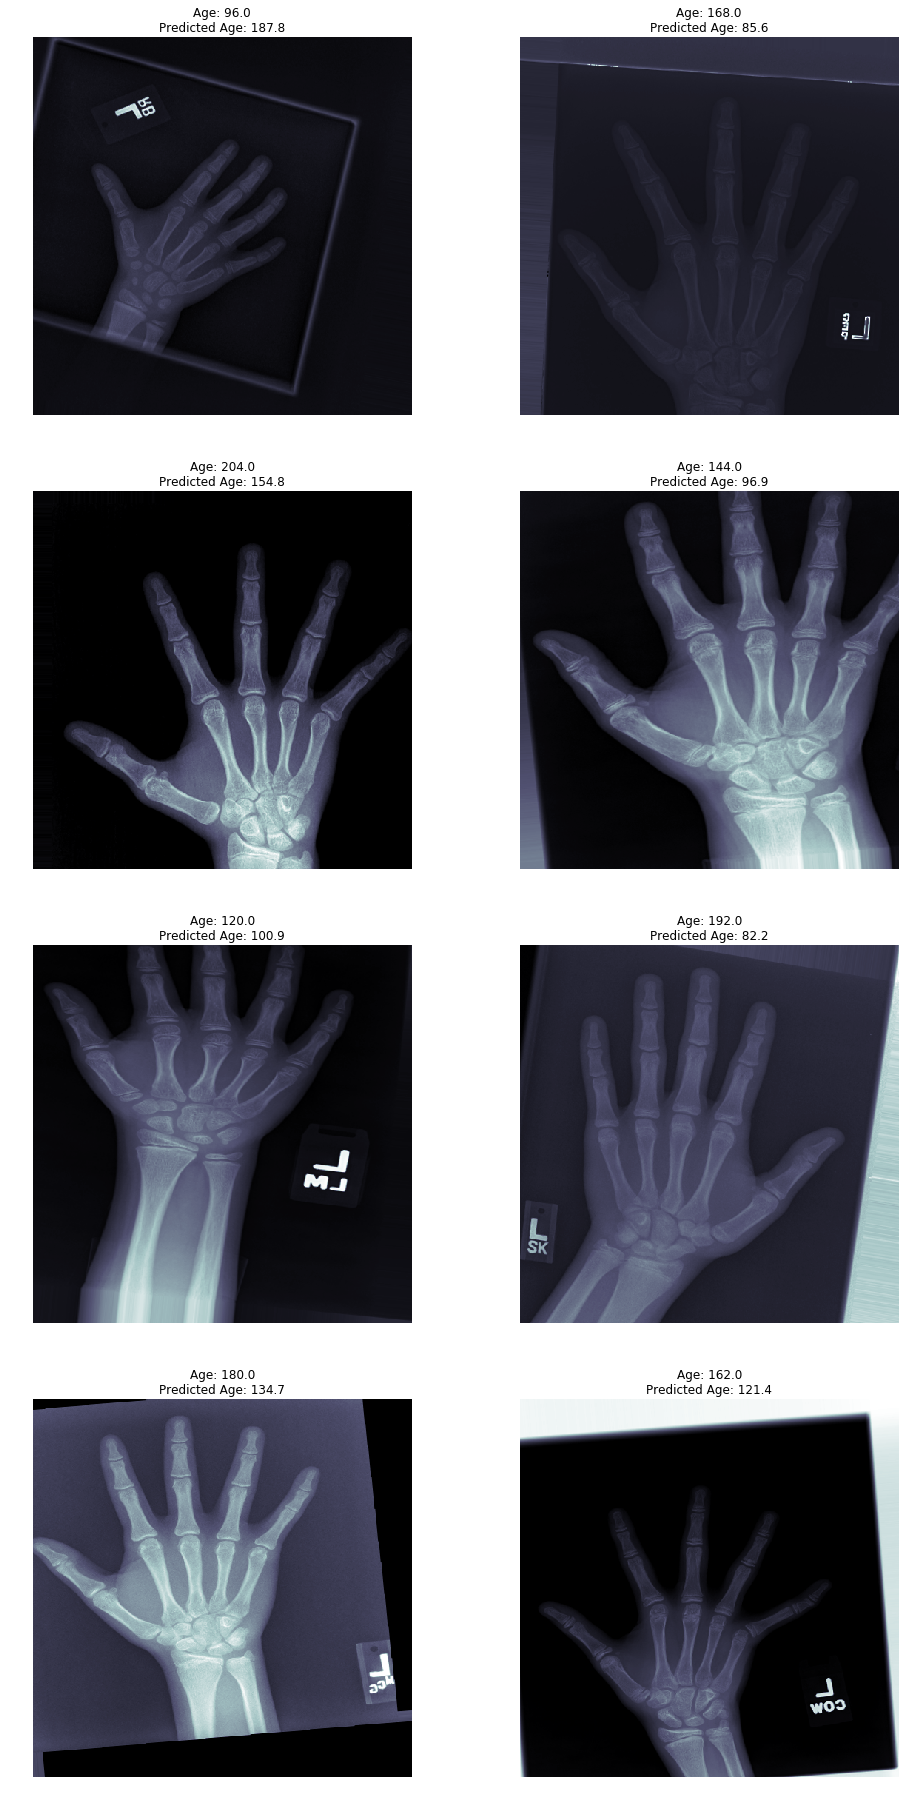

In [85]:
rand_idx = np.random.choice(range(test_X.shape[0]), 8)
fig, axis = plt.subplots(4, 2, figsize = (16, 32))
for (index, axis_) in zip(rand_idx, axis.flatten()):
        axis_.imshow(test_x[index, :,:,0], cmap = 'bone')
        axis_.set_title('Age: %2.1f\nPredicted Age: %2.1f' % (test_month_target[index], pred[index]))
        axis_.axis('off')
